# Notebook to visualize all the tissues and labels of the mask

### Label = 0
Background

### Necrotic and Non-Enhancing Tumor Core (Label = 1) (NCR NET)
- The necrotic part is the dead tissue in the center of the tumor, caused by poor blood supply.
- The non-enhancing part is tumor tissue that does not take up contrast agent (on T1ce MRI), meaning the blood–brain barrier there is intact or the tissue is non-viable.

Appearance:
- On T1ce (contrast-enhanced) MRI → Dark (no enhancement)
- On T2/FLAIR → Can appear bright or heterogeneous
- It’s the “core” of the tumor that doesn’t light up even after contrast injection.

Indicates old or dead tumor regions, not actively growing. Often sits in the center, surrounded by the enhancing rim. As the brain tumor grows, it becomes dense and metabolically active. the inner regions of the timor outgrow their blood suply (they are too far from capillaries to get enough oxygen)

### Peritumoral Edema (Label = 2)
- Swelling or fluid accumulation around the tumor. Caused by the tumor disrupting the blood–brain barrier and leaking fluid into the surrounding brain tissue.

Appearance:
- On FLAIR/T2 → Very bright (hyperintense)
- On T1ce → Usually dark or grayish (no enhancement)

Not tumor cells themselves, but swollen brain tissue affected by the tumor’s presence. Important for surgical planning and radiotherapy margins.

### Label = 3
corresponds to a class no longer used but the number is still "active yet unused" for compatibility reasons with old code

### Enhancing Tumor (Label = 4)
- Active tumor tissue that takes up the contrast agent on T1ce images.
- Indicates areas where the blood–brain barrier is disrupted and tumor cells are actively growing or invading.

Appearance:
- On T1ce → Bright or white (strong enhancement)
- On FLAIR/T2 → Often also bright but less distinct than in T1ce

The most aggressive and clinically significant part of the tumor. Often forms a bright ring or patch around the necrotic core.

### Separation task:
Whole tumor (WT): all labels (1 + 2 + 4)

Tumor core (TC): only labels 1 + 4

Enhancing tumor (ET): label 4 only

In [114]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os

In [115]:
import subprocess

try:
    subprocess.run(['bash', 'mount_usb.sh'], check=True)
    print("Mount succeeded via bash script!")
except subprocess.CalledProcessError as e:
    print("Mount failed:", e)


Mount succeeded via bash script!


In [ ]:
def get_path(root = "/mnt/d/MICCAI_BraTS_2020/BraTS20_Training_", patient='001', type="t1ce", mask="seg", extension=".nii"): # SET PATH

    image_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + type + extension)
    mask_path = os.path.join(root + patient, root.split('/')[-1] + patient + '_' + mask + extension)

    print("Loading image NIfTI file from:", image_path)
    print("Loading mask NIfTI file from:", mask_path)
    
    return image_path, mask_path

def load_brain(image_path, mask_path): # FIRST LOAD FILE AND THEN GET DATA
    # Load NIfTI files
    img = nib.load(image_path)
    mask_img = nib.load(mask_path)

    # Get data arrays
    brain = img.get_fdata() # (240, 240, 155)
    mask = mask_img.get_fdata() # (240, 240, 155)
    
    # transpose ONCE so that training npy, png and plots are in correct orientation
    brain = brain.transpose(1, 0, 2)
    mask = mask.transpose(1, 0, 2)

    
    return brain, mask

def slice_axial(brain, mask, patient, slice_index): # SLICE
    slice_brain = brain[:, :, slice_index]
    slice_mask = mask[:, :, slice_index]
    
    # save the slice as .npy file and .png file in folder (create if not exists)
    if not os.path.exists("training_set_npy"):
        os.makedirs("training_set_npy")
    np.save(os.path.join("training_set_npy", f"{patient}_{slice_index}.npy"), slice_brain)
    np.save(os.path.join("training_set_npy", f"{patient}_{slice_index}_mask.npy"), slice_mask)

    if not os.path.exists("training_set_png"):
        os.makedirs("training_set_png")
        
    plt.imsave(os.path.join("training_set_png", f"{patient}_{slice_index}.png"), slice_brain, cmap='gray')
    plt.imsave(os.path.join("training_set_png", f"{patient}_{slice_index}_mask.png"), slice_mask, cmap='hot') # keep labels, not grayscale value
    print(f"Saved slice {slice_index} as .npy and .png in folder.")
    return slice_brain, slice_mask

def plot_labels(patient, slice_num, slice_brain, slice_mask):
    hex_colors = {
        0: "#aca9c5",   # blue/grey - Background
        1: "#000000",   # black - Necrotic core
        2: "#89e6ad",   # light green - Edema
        4: "#d62728"    # red - Enhancing tumor
        # Note: Label 3 is typically skipped in BraTS
    }

    # Find unique labels for the subtitle of the plot
    raw_unique_values = np.unique(slice_mask)
    # Convert to integer
    present_labels = raw_unique_values.astype(int)

    # create colormap: include placeholder for label 3 (white)
    custom_cmap = ListedColormap([hex_colors.get(i, "#ffffff") for i in range(5)])

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # .T is for transpose, 'origin='lower'' for medical imaging convention
    axs[0].imshow(slice_brain, cmap='gray')
    axs[0].set_title("T1ce Slice")

    axs[1].imshow(slice_brain, cmap='gray')
    # Alpha = semi-transparent
    axs[1].imshow(slice_mask, cmap=custom_cmap, alpha=0.4, vmin=0, vmax=4) # vmin/vmax to map colors correctly
    axs[1].set_title("T1ce + Segmentation Overlay")
    
    tumor_labels = sorted([l for l in present_labels if l != 0]) #to see if there is another thing that is not background
    if tumor_labels:
        labels_info = f"Present Labels: {', '.join(map(str, sorted(present_labels)))}"
    else:
        labels_info = "No tumor/lesion labels (1, 2, or 4) present"

    plt.suptitle(
        f"Patient: {patient}, Slice: {slice_num}\n{labels_info}",
        fontsize=12
    )

    legend_labels = {
        "0 - Background": hex_colors[0],
        "1 - Necrotic core": hex_colors[1],
        "2 - Edema": hex_colors[2],
        "4 - Enhancing tumor": hex_colors[4]
    }

    patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]

    plt.legend(
        handles=patches,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        facecolor='white',
        edgecolor='black'
    )

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


In [117]:
training_dataset_dict = {}
print("Initial dictionary (empty):", training_dataset_dict)


Initial dictionary (empty): {}


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_001/BraTS20_Training_001_seg.nii


Saved slice 49 as .npy and .png in folder.


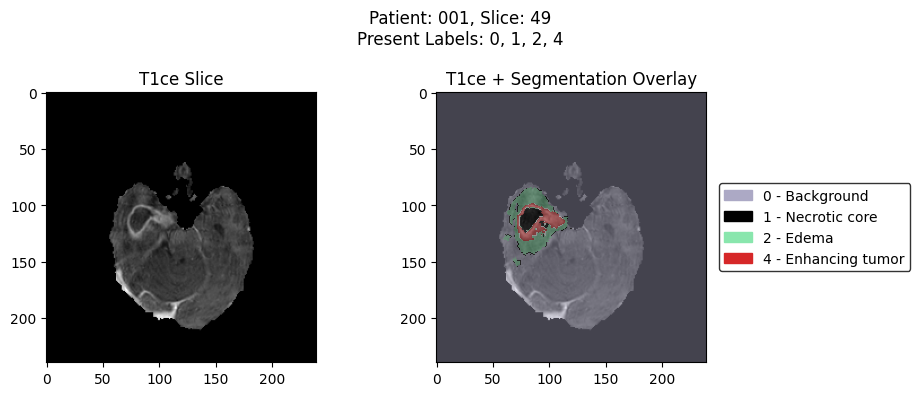

In [118]:
patient='001'
slice_index = 49

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_003/BraTS20_Training_003_seg.nii
Saved slice 69 as .npy and .png in folder.


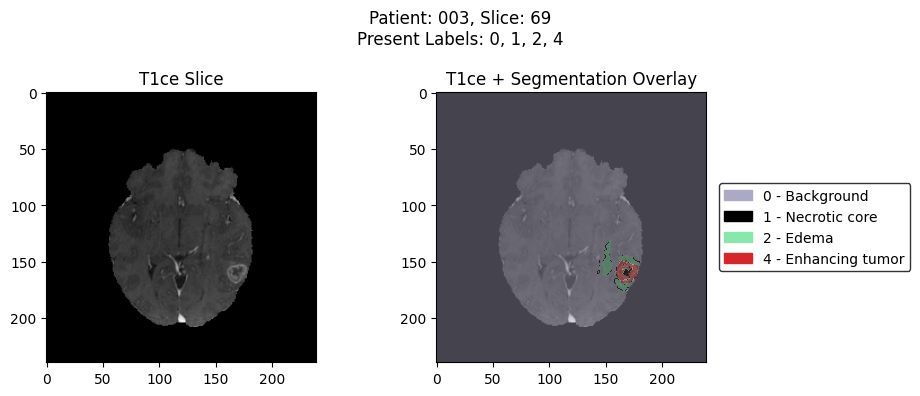

In [119]:
patient='003'
slice_index = 69

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_349/BraTS20_Training_349_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_349/BraTS20_Training_349_seg.nii
Saved slice 99 as .npy and .png in folder.


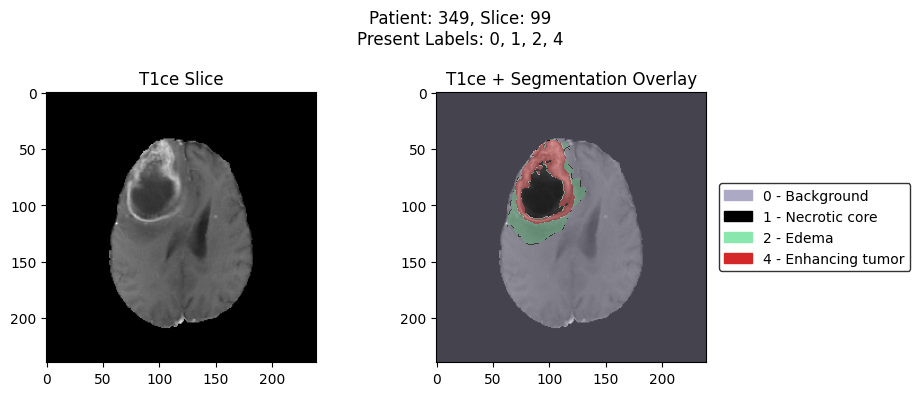

In [120]:
patient='349'
slice_index = 99

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_362/BraTS20_Training_362_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_362/BraTS20_Training_362_seg.nii
Saved slice 68 as .npy and .png in folder.


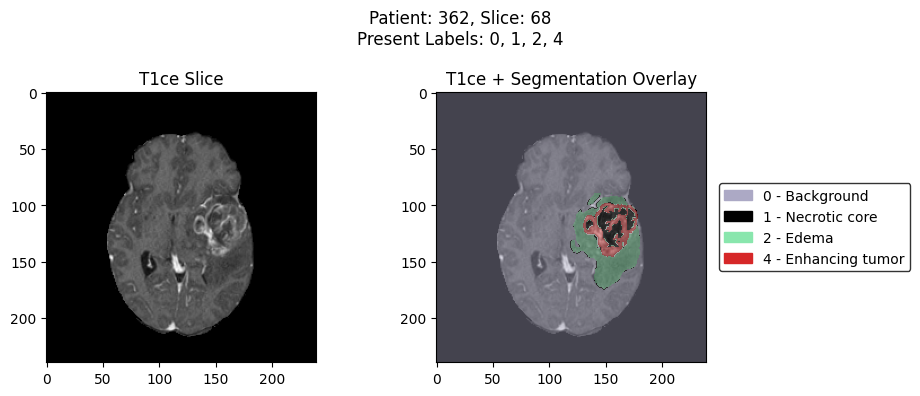

In [121]:
patient='362'
slice_index = 68

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_234/BraTS20_Training_234_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_234/BraTS20_Training_234_seg.nii
Saved slice 39 as .npy and .png in folder.


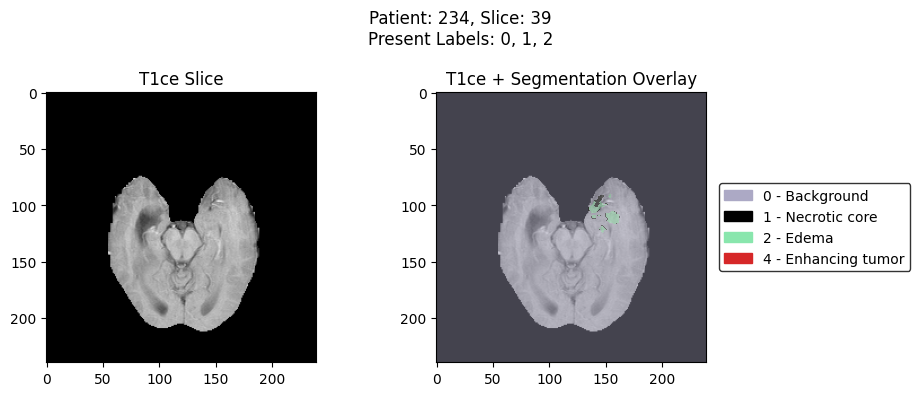

In [122]:
patient='234'
slice_index = 39

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_162/BraTS20_Training_162_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_162/BraTS20_Training_162_seg.nii
Saved slice 106 as .npy and .png in folder.


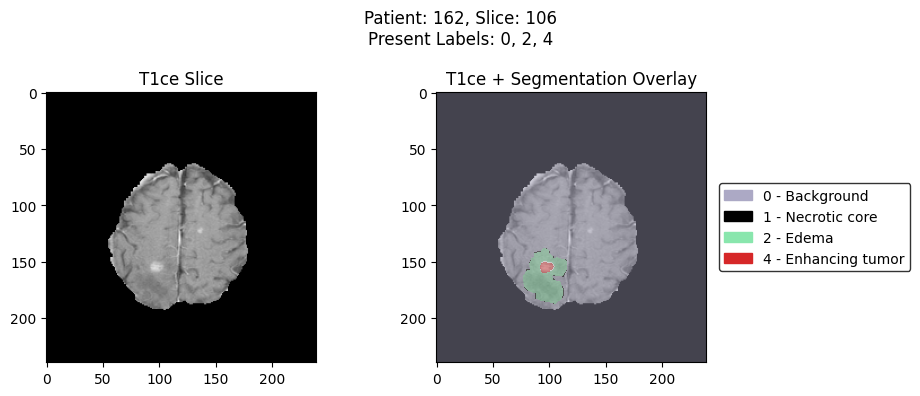

In [123]:
patient='162'
slice_index = 106

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_187/BraTS20_Training_187_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_187/BraTS20_Training_187_seg.nii
Saved slice 122 as .npy and .png in folder.


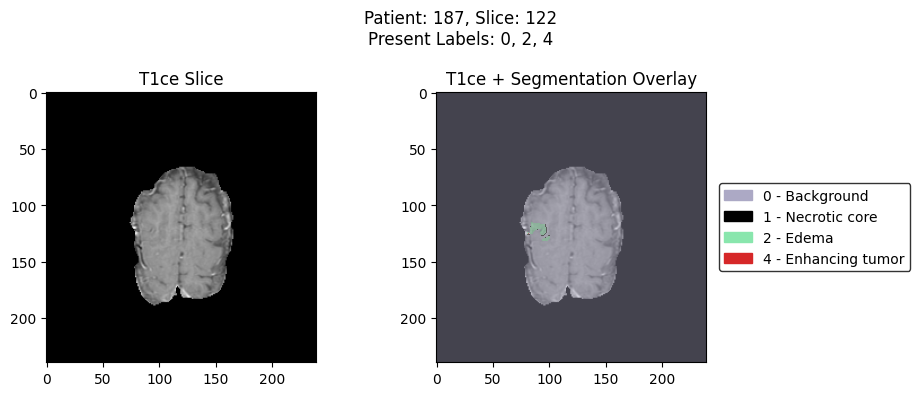

In [124]:
patient='187'
slice_index = 122

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_183/BraTS20_Training_183_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_183/BraTS20_Training_183_seg.nii
Saved slice 66 as .npy and .png in folder.


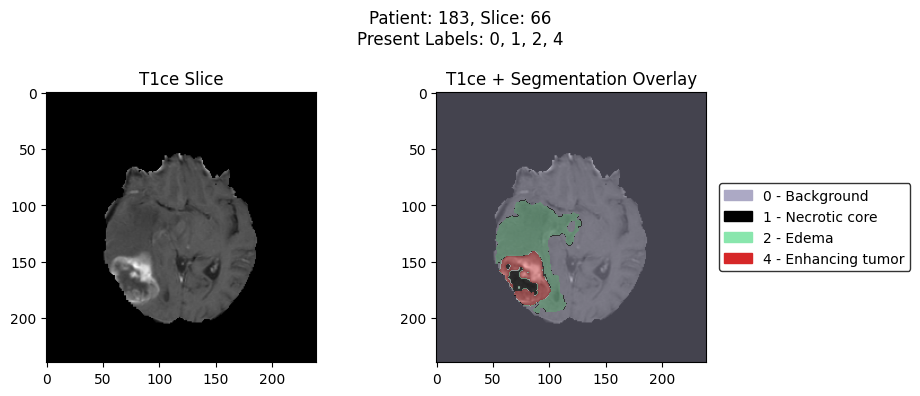

In [125]:
patient='183'
slice_index = 66

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index) 
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_265/BraTS20_Training_265_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_265/BraTS20_Training_265_seg.nii
Saved slice 75 as .npy and .png in folder.


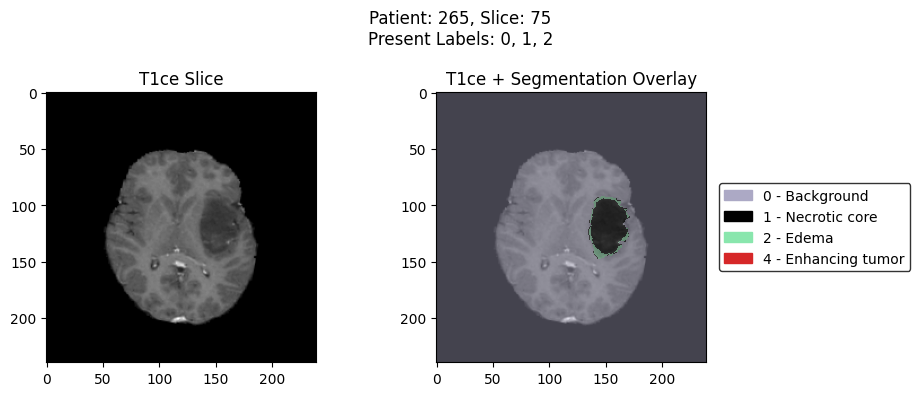

In [126]:
patient='265'
slice_index = 75

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_224/BraTS20_Training_224_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_224/BraTS20_Training_224_seg.nii
Saved slice 71 as .npy and .png in folder.


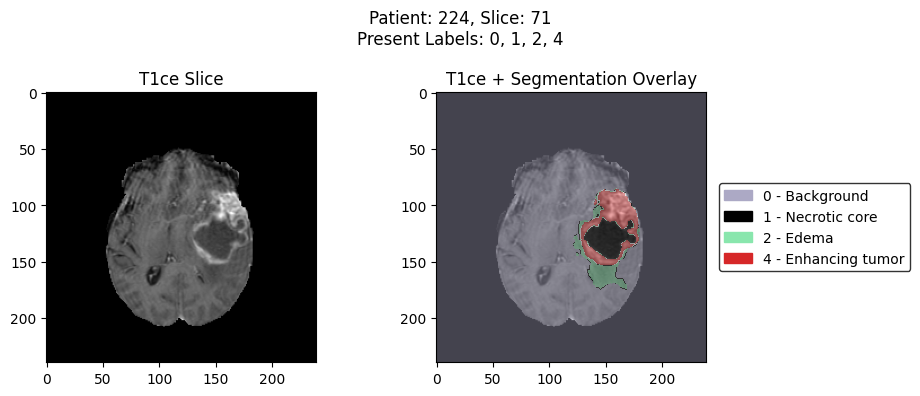

In [127]:
patient='224'
slice_index = 71

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_288/BraTS20_Training_288_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_288/BraTS20_Training_288_seg.nii
Saved slice 45 as .npy and .png in folder.


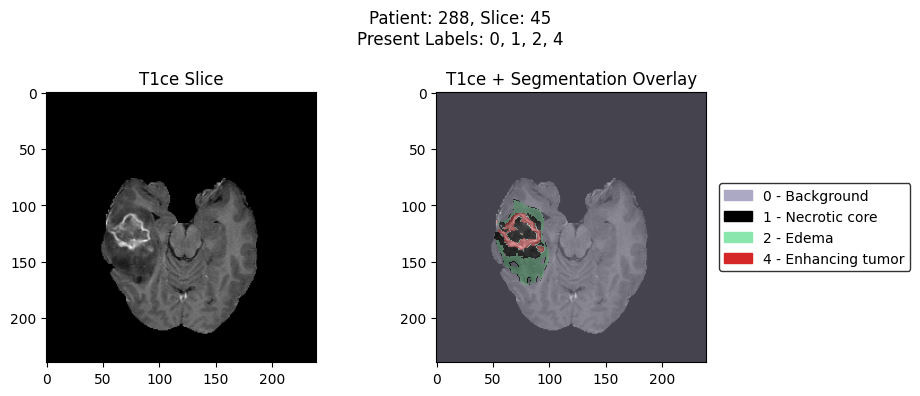

In [128]:
patient='288'
slice_index = 45

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_249/BraTS20_Training_249_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_249/BraTS20_Training_249_seg.nii
Saved slice 54 as .npy and .png in folder.


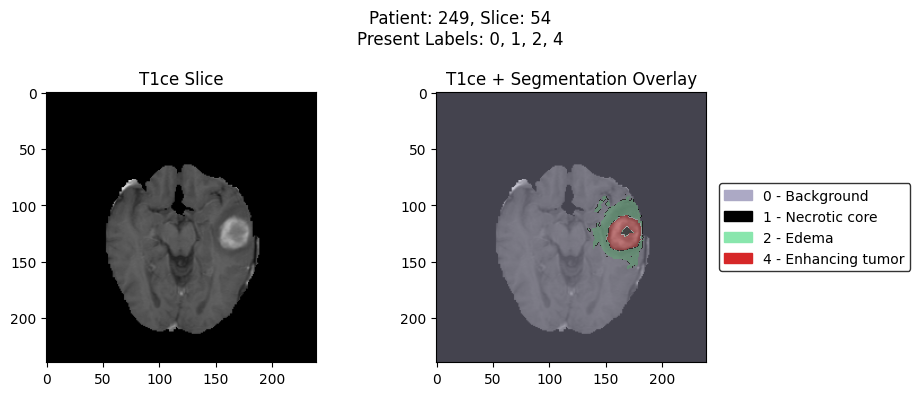

In [129]:
patient='249'
slice_index = 54

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_115/BraTS20_Training_115_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_115/BraTS20_Training_115_seg.nii
Saved slice 123 as .npy and .png in folder.


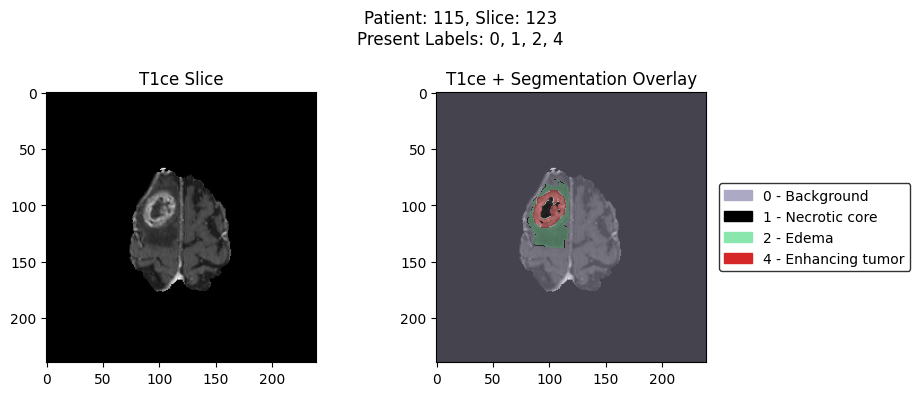

In [130]:
patient='115'
slice_index = 123

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_298/BraTS20_Training_298_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_298/BraTS20_Training_298_seg.nii
Saved slice 78 as .npy and .png in folder.


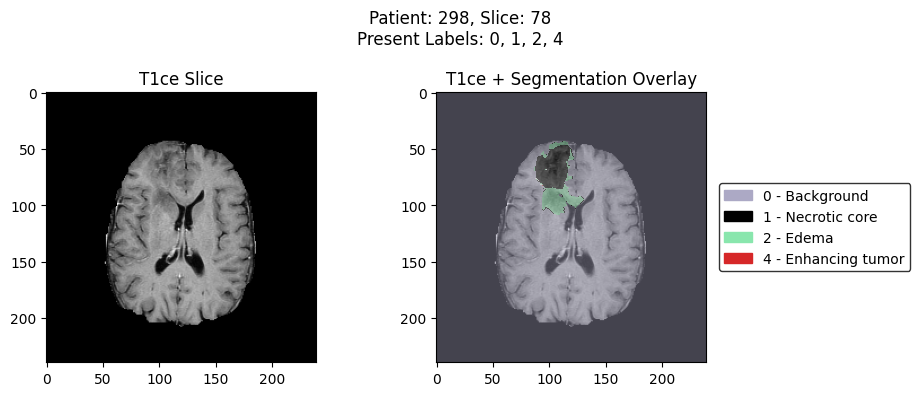

In [131]:
patient='298'
slice_index = 78

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_027/BraTS20_Training_027_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_027/BraTS20_Training_027_seg.nii
Saved slice 61 as .npy and .png in folder.


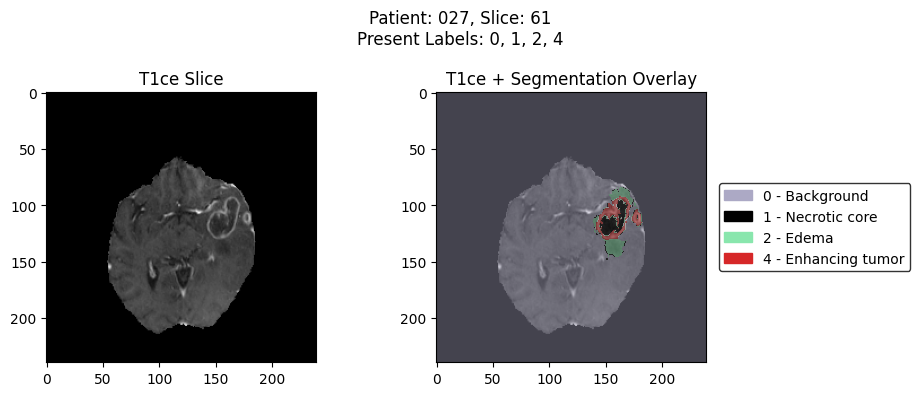

In [132]:
patient='027'
slice_index = 61

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_146/BraTS20_Training_146_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_146/BraTS20_Training_146_seg.nii


Saved slice 45 as .npy and .png in folder.


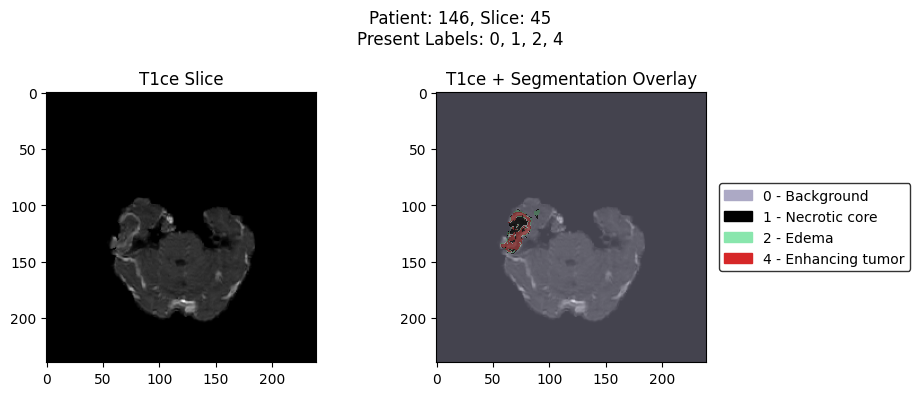

In [133]:
patient='146'
slice_index = 45

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_091/BraTS20_Training_091_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_091/BraTS20_Training_091_seg.nii
Saved slice 92 as .npy and .png in folder.


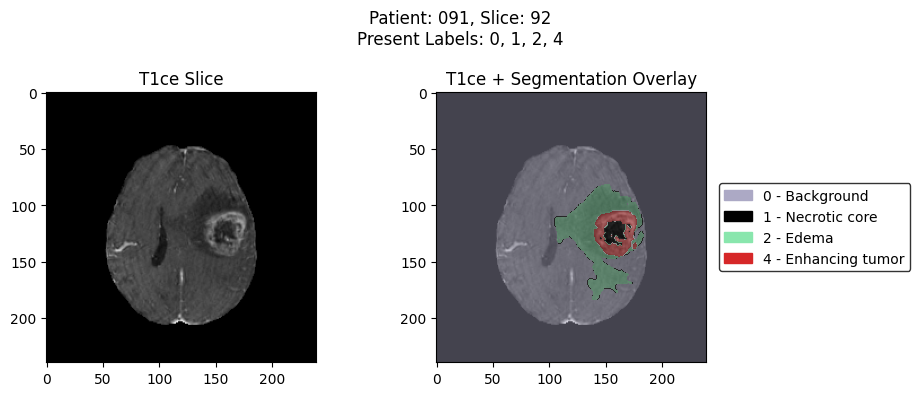

In [134]:
patient='091'
slice_index = 92

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_152/BraTS20_Training_152_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_152/BraTS20_Training_152_seg.nii
Saved slice 100 as .npy and .png in folder.


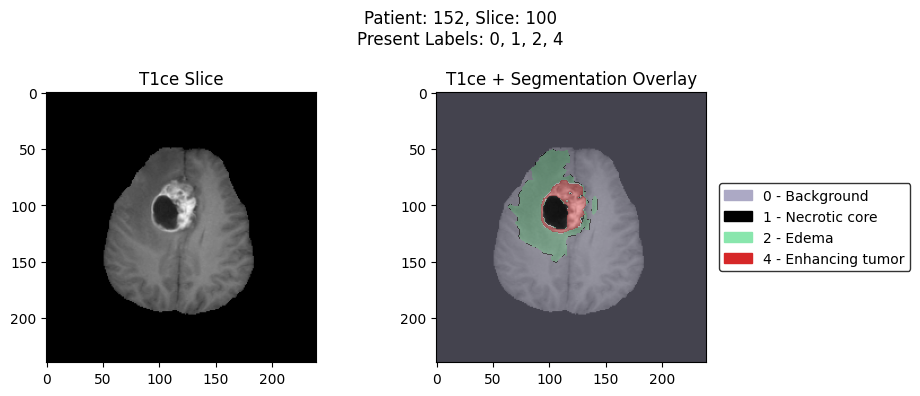

In [135]:
patient='152'
slice_index = 100

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_089/BraTS20_Training_089_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_089/BraTS20_Training_089_seg.nii
Saved slice 46 as .npy and .png in folder.


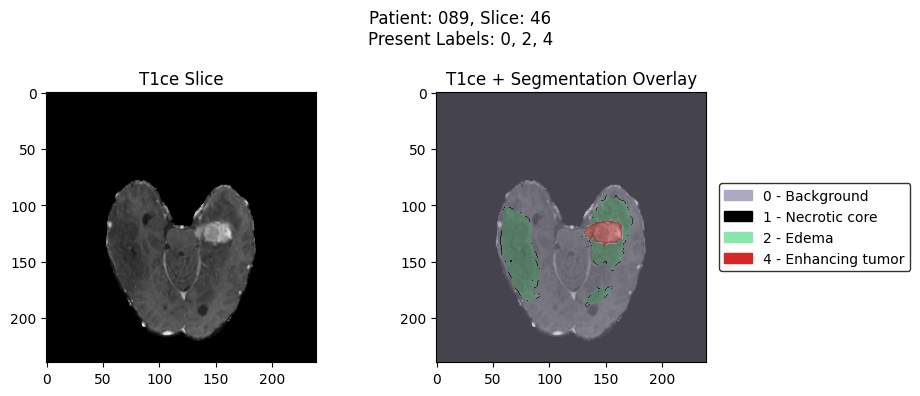

In [136]:
patient='089'
slice_index = 46

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_037/BraTS20_Training_037_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_037/BraTS20_Training_037_seg.nii
Saved slice 83 as .npy and .png in folder.


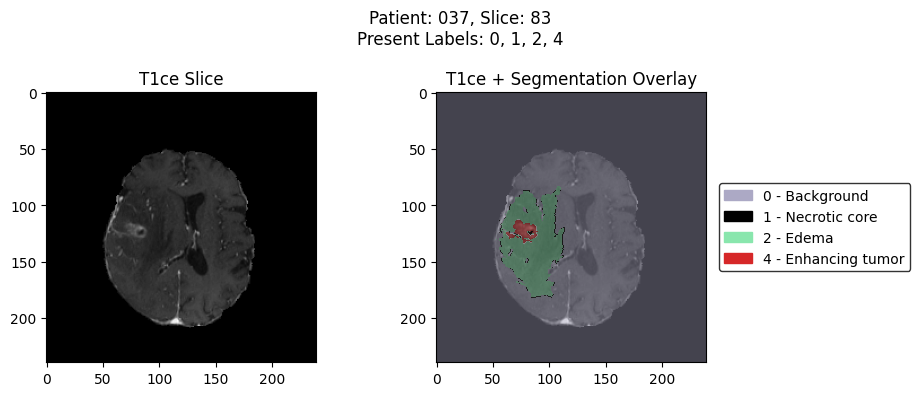

In [137]:
patient='037'
slice_index = 83

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_047/BraTS20_Training_047_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_047/BraTS20_Training_047_seg.nii
Saved slice 87 as .npy and .png in folder.


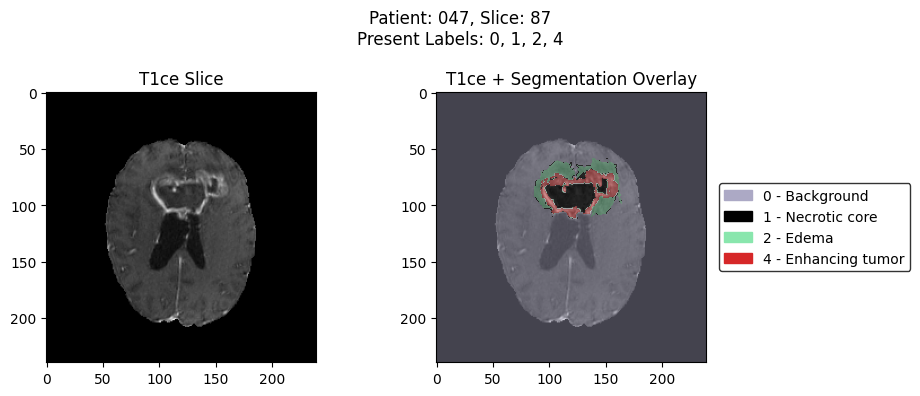

In [138]:
patient='047'
slice_index = 87

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_153/BraTS20_Training_153_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_153/BraTS20_Training_153_seg.nii


Saved slice 61 as .npy and .png in folder.


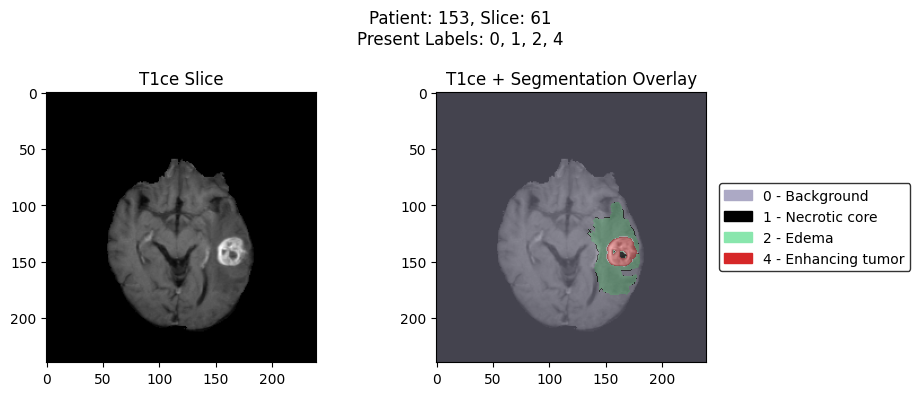

In [139]:
patient='153'
slice_index = 61

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_170/BraTS20_Training_170_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_170/BraTS20_Training_170_seg.nii
Saved slice 67 as .npy and .png in folder.


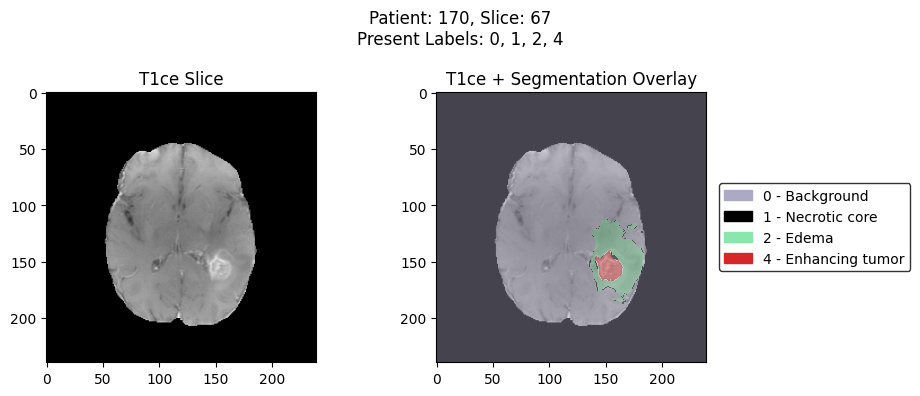

In [140]:
patient='170'
slice_index = 67

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_235/BraTS20_Training_235_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_235/BraTS20_Training_235_seg.nii
Saved slice 114 as .npy and .png in folder.


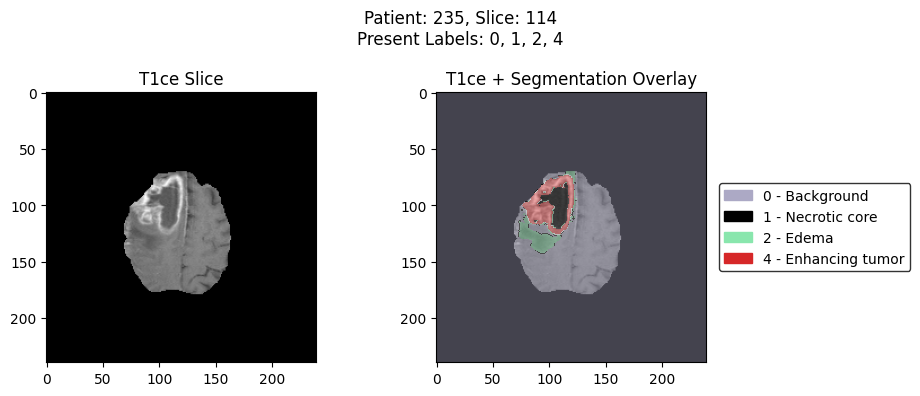

In [141]:
patient='235'
slice_index = 114

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_025/BraTS20_Training_025_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_025/BraTS20_Training_025_seg.nii
Saved slice 109 as .npy and .png in folder.


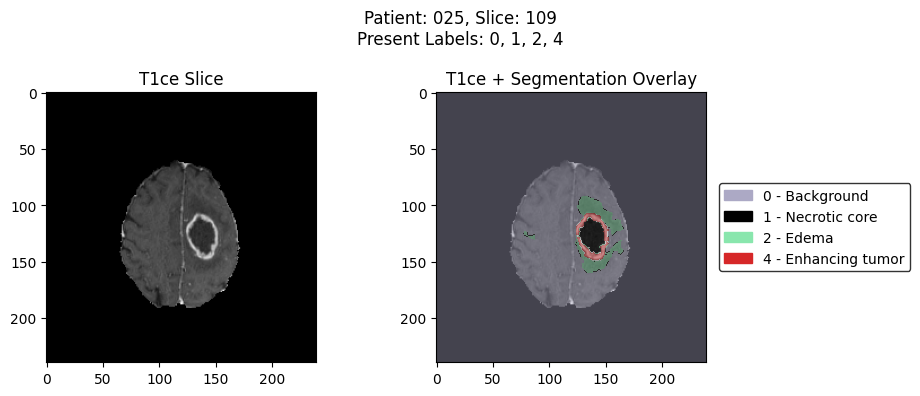

In [142]:
patient='025'
slice_index = 109

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_364/BraTS20_Training_364_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_364/BraTS20_Training_364_seg.nii
Saved slice 25 as .npy and .png in folder.


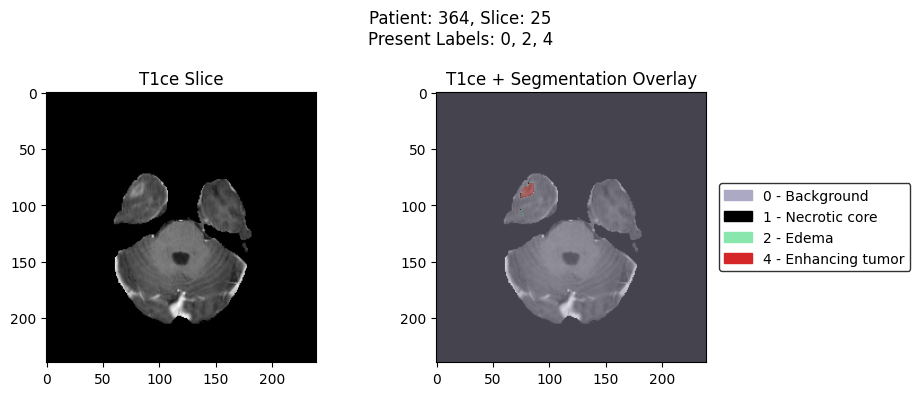

In [143]:
patient='364'
slice_index = 25

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_020/BraTS20_Training_020_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_020/BraTS20_Training_020_seg.nii
Saved slice 26 as .npy and .png in folder.


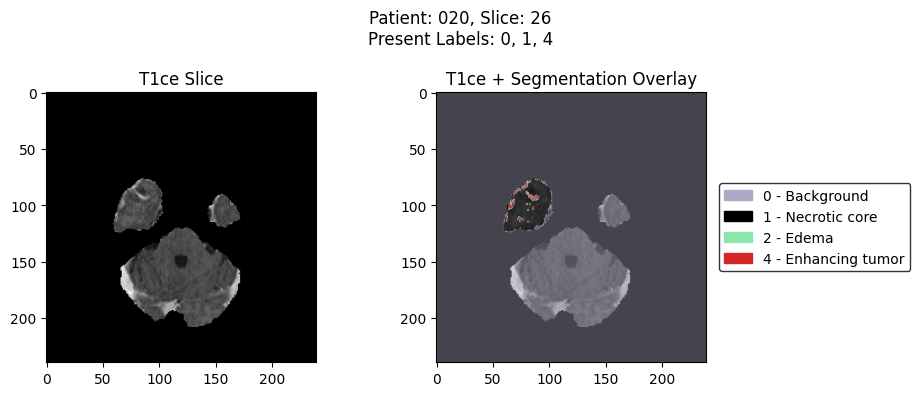

In [144]:
patient='020'
slice_index = 26

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_325/BraTS20_Training_325_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_325/BraTS20_Training_325_seg.nii
Saved slice 17 as .npy and .png in folder.


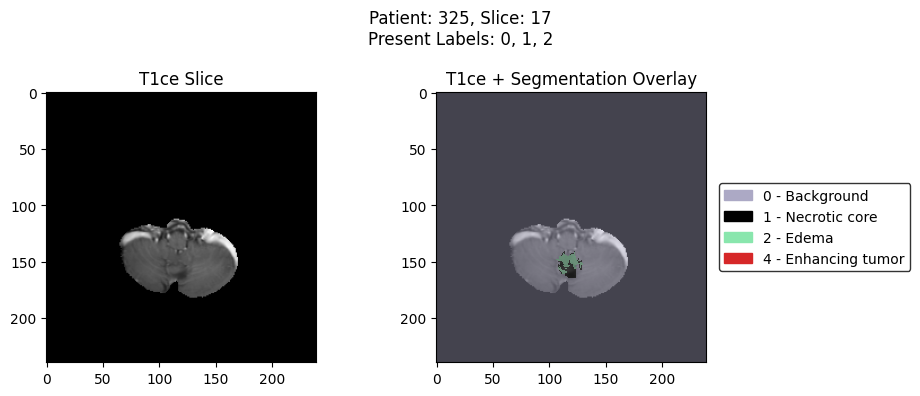

In [145]:
patient='325'
slice_index = 17

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index


Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_355/BraTS20_Training_355_seg.nii
Saved slice 93 as .npy and .png in folder.


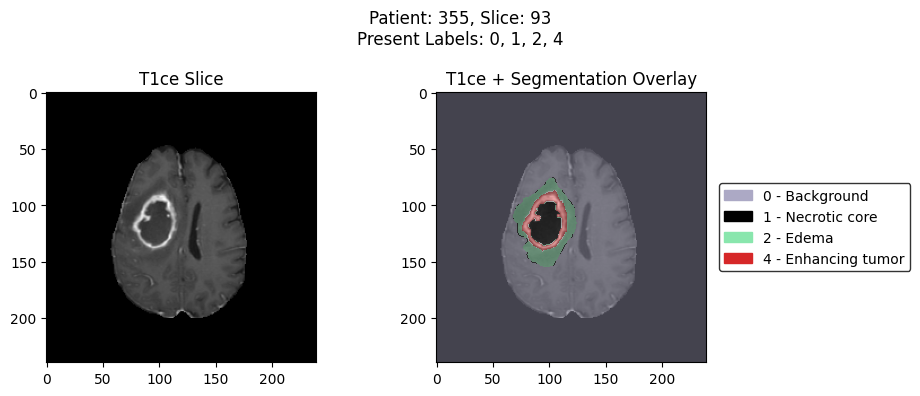

In [146]:
patient='355'
slice_index = 93

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index

Loading image NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_225/BraTS20_Training_225_t1ce.nii
Loading mask NIfTI file from: /mnt/d/MICCAI_BraTS_2020/BraTS20_Training_225/BraTS20_Training_225_seg.nii
Saved slice 94 as .npy and .png in folder.


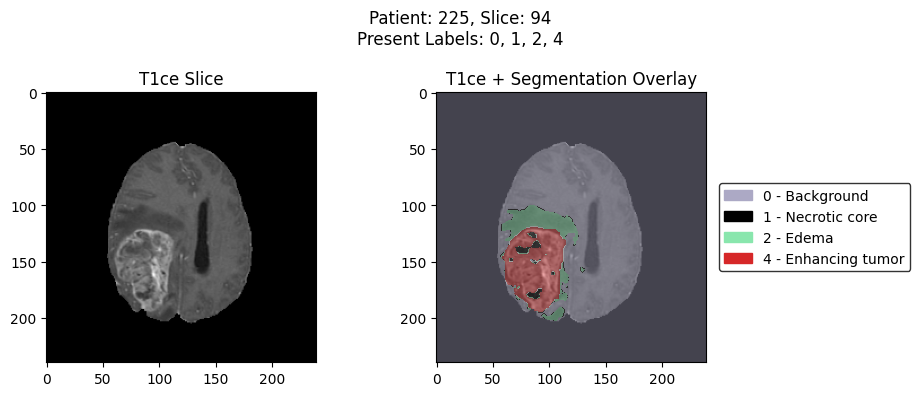

In [147]:
patient='225'
slice_index = 94

image_path, mask_path = get_path(patient = patient)
brain, mask = load_brain(image_path, mask_path)
slice_img, slice_mask = slice_axial(brain, mask, patient, slice_index)
plot_labels(patient, slice_index, slice_img, slice_mask)

training_dataset_dict[patient] = slice_index

In [148]:
# sort keys and keep the values with their keys
sorted_training_dataset_dict = dict(sorted(training_dataset_dict.items()))
# print
for patient, slice_index in sorted_training_dataset_dict.items():
    print(f"Patient: {patient}, Slice Index: {slice_index}")
    
print(len(sorted_training_dataset_dict), "total patients in training set.")

#save csv of the dictionary
# import pandas as pd
# df = pd.DataFrame(list(sorted_training_dataset_dict.items()), columns=['Patient', 'SliceIndex'])
# df.to_csv('training_dataset_slices.csv', index=False)

Patient: 001, Slice Index: 49
Patient: 003, Slice Index: 69
Patient: 020, Slice Index: 26
Patient: 025, Slice Index: 109
Patient: 027, Slice Index: 61
Patient: 037, Slice Index: 83
Patient: 047, Slice Index: 87
Patient: 089, Slice Index: 46
Patient: 091, Slice Index: 92
Patient: 115, Slice Index: 123
Patient: 146, Slice Index: 45
Patient: 152, Slice Index: 100
Patient: 153, Slice Index: 61
Patient: 162, Slice Index: 106
Patient: 170, Slice Index: 67
Patient: 183, Slice Index: 66
Patient: 187, Slice Index: 122
Patient: 224, Slice Index: 71
Patient: 225, Slice Index: 94
Patient: 234, Slice Index: 39
Patient: 235, Slice Index: 114
Patient: 249, Slice Index: 54
Patient: 265, Slice Index: 75
Patient: 288, Slice Index: 45
Patient: 298, Slice Index: 78
Patient: 325, Slice Index: 17
Patient: 349, Slice Index: 99
Patient: 355, Slice Index: 93
Patient: 362, Slice Index: 68
Patient: 364, Slice Index: 25
30 total patients in training set.


## UNMOUNT:

In [150]:
import subprocess

print("--- Running Unmount Script ---")
try:
    subprocess.run(['bash', 'unmount_usb.sh'], check=True)
    print("SUCCESS: USB drive unmounted from /mnt/d")
except subprocess.CalledProcessError as e:
    print(f"ERROR: Unmount failed: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


--- Running Unmount Script ---
SUCCESS: USB drive unmounted from /mnt/d


EXTRA CODE I MIGHT NEED